# Question 3 Clustering

## 3a. Implement k-means

parameter: k (number of clusters), X (training data)

return: group assignment for each point, mean (center) of each group

initialize each cluster center by choosing a random point from the data

1. cluster center fixed, assign each point to its closest cluster center (Euclidean distance)

2. point cluster assignment fixed, adjust cluster centers as average of points in the cluster

In [1]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
def has_converged(a, b):
    '''
    tell if 2 numpy arrays are element-wise equal within a tolerance
    '''
    if (a is None or a is None):
        return False
    assert a.shape[0] == b.shape[0]
    assert a.shape[1] == b.shape[1]
    # Returns True if two arrays are element-wise equal within a tolerance.
    return np.allclose(a, b)

In [3]:
def initialize_centers(k, X):
    '''
    generate random centers for k clusters,
    by picking k random points from the dataset X
    '''
    p = X.shape[1]
    centers = np.zeros((k, p))
    n = X.shape[0]
    random_indices = np.random.randint(0, n, size=k)
    for i in range(k):
        centers[i, :] = X[random_indices[i], :]
    return centers

In [4]:
def assign_point_label(X, centers):
    '''
    generate labels for each data point in X, given k center locations
    '''
    assert X.shape[1] == centers.shape[1]
    # distances: n * k numpy array, see the function documentation
    distances = euclidean_distances(X, centers)
    # find the index of minimal distance (cluster index) in each row (each point)
    labels = np.argmin(distances, axis=1)
    assert labels.shape[0] == X.shape[0]
    return labels

In [5]:
def update_cluster_center(k, X, clusters):
    '''
    generate cluster center for each cluster, as the mean of all points in the cluster
    '''
    p = X.shape[1]
    centers = np.zeros([k, p])
    for i in range(k):
        centers[i, :] = np.mean(X[clusters == i, :], axis=0)
    return centers

In [6]:
class MyKMeans():
    n_clusters_ = None
    labels_= None
    cluster_centers_ = None
    
    def __init__(self, n_clusters):
        self.n_clusters_ = n_clusters
        self.labels_ = None
        self.cluster_centers_ = None

    def fit(self, X):
        n, p = X.shape
        self.labels_ = None
        centers_old = None
        self.cluster_centers_ = initialize_centers(self.n_clusters_, X)
        while (not has_converged(centers_old, self.cluster_centers_)):
            self.labels_ = assign_point_label(X, self.cluster_centers_)
            centers_old = self.cluster_centers_
            self.cluster_centers_ = update_cluster_center(self.n_clusters_, X, self.labels_)
        return self

## 3b. Implement hierarchical agglomerative clustering

parameter: k (number of clusters), X (training data)

return: group assignment for each point

Initialize each point into its own cluster.

Recursively merge the clusters of 2 closest points (based on Euclidean distance), until there are k clusters left.

In [7]:
def compute_all_distances(X):
    distances = euclidean_distances(X)
    return distances

In [8]:
class DisjointSet():
    count = None
    sets = None
    def __init__(self, n):
        self.count = n
        self.sets = list()
        for i in range(n):
            # -1 * the number of nodes in the tree
            self.sets.append(-1)
    
    def find(self, i):
        '''
        recursively find the root value of value i, and flatten the path
        '''
        if self.sets[i] < 0:
            return i
        self.sets[i] = self.find(self.sets[i])
        return self.sets[i]
    
    def union(self, i, j):
        '''
        union the sets that value i and value j are in
        '''
        root_i = self.find(i)
        root_j = self.find(j)
        if root_i == root_j:
            return
        # make the root with more nodes as the root
        if root_i < root_j: # tree root_i
            self.sets[root_i] += self.sets[root_j]
            self.sets[root_j] = root_i
        else:
            self.sets[root_j] += self.sets[root_i]
            self.sets[root_i] = root_j
        self.count -= 1
    
    def get_roots(self):
        roots = list()
        for i in range(len(self.sets)):
            if self.sets[i] < 0:
                roots.append(i)
        assert len(roots) == self.count
        return roots

In [9]:
class MyHierarchicalAgglomerativeClustering():
    n_clusters_ = None
    labels_ = None
    
    def __init__(self, n_clusters):
        self.labels_ = list()
        self.n_clusters_ = n_clusters
    
    def fit(self, X):
        n = X.shape[0]
        distances = compute_all_distances(X)
        root_children = DisjointSet(n)
        for i in range(n):
            distances[i, i] = float('inf')
        while (root_children.count != self.n_clusters_):
            (i, j) = np.unravel_index(distances.argmin(), distances.shape)
            distances[i, j] = float('inf')
            distances[j, i] = float('inf')
            root_children.union(i, j)
        self.labels_ = list()
        roots = root_children.get_roots()
        for i in range(n):
            # the index of its root in roots
            root = root_children.find(i)
            self.labels_.append(roots.index(root))
        self.labels_ = np.asarray(self.labels_)
        return self

## 3c. Run algorithms on dataset, with k = 2

In [10]:
X = np.genfromtxt('data.csv', delimiter=',')

### k-means

In [11]:
kmeans = MyKMeans(2).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
X_0 = X[labels == 0]
X_1 = X[labels == 1]

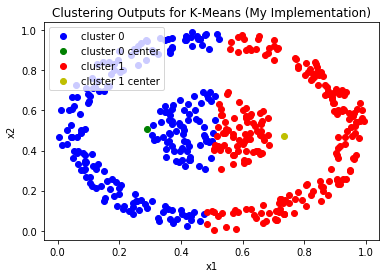

In [12]:
plt.plot(X_0[:, 0], X_0[:, 1], 'bo', label='cluster 0')
plt.plot(centers[0, 0], centers[0, 1], 'go', label='cluster 0 center')
plt.plot(X_1[:, 0], X_1[:, 1], 'ro', label='cluster 1')
plt.plot(centers[1, 0], centers[1, 1], 'yo', label='cluster 1 center')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Clustering Outputs for K-Means (My Implementation)')
plt.show()

verify with sklearn package

In [13]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_
centers_pkg = kmeans.cluster_centers_
X_0_pkg = X[labels == 0]
X_1_pkg = X[labels == 1]

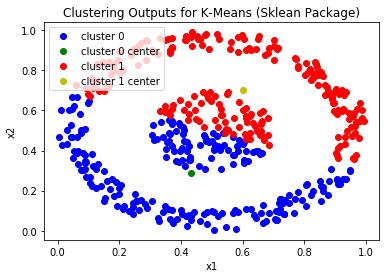

In [14]:
plt.plot(X_0_pkg[:, 0], X_0_pkg[:, 1], 'bo', label='cluster 0')
plt.plot(centers_pkg[0, 0], centers_pkg[0, 1], 'go', label='cluster 0 center')
plt.plot(X_1_pkg[:, 0], X_1_pkg[:, 1], 'ro', label='cluster 1')
plt.plot(centers_pkg[1, 0], centers_pkg[1, 1], 'yo', label='cluster 1 center')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Clustering Outputs for K-Means (Sklean Package)')
plt.show()

So the output of my implementation is pretty similar to that of the Sklearn package.

### hierarchical agglomerative clustering

In [15]:
hac = MyHierarchicalAgglomerativeClustering(2).fit(X)
labels = hac.labels_
X_0 = X[labels == 0]
X_1 = X[labels == 1]

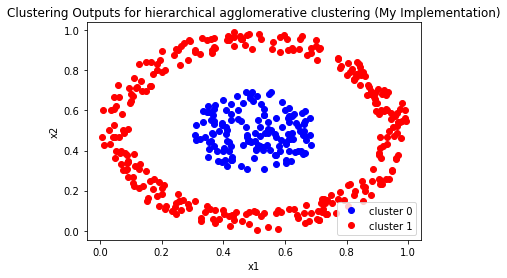

In [16]:
plt.plot(X_0[:, 0], X_0[:, 1], 'bo', label='cluster 0')
plt.plot(X_1[:, 0], X_1[:, 1], 'ro', label='cluster 1')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Clustering Outputs for hierarchical agglomerative clustering (My Implementation)')
plt.show()

verify with Sklean package

In [17]:
ac_pkg = AgglomerativeClustering(n_clusters=2).fit(X)
labels = ac_pkg.labels_
X_0_pkg = X[labels == 0]
X_1_pkg = X[labels == 1]

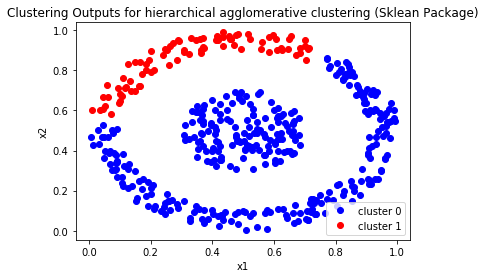

In [18]:
plt.plot(X_0_pkg[:, 0], X_0_pkg[:, 1], 'bo', label='cluster 0')
plt.plot(X_1_pkg[:, 0], X_1_pkg[:, 1], 'ro', label='cluster 1')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Clustering Outputs for hierarchical agglomerative clustering (Sklean Package)')
plt.show()

## 3d. Preprocess X to make K-Means perform better

In [29]:
from sklearn.preprocessing import normalize

In [42]:
x12 = X[:, 0] ** 2
X_new = np.append(X, x12.reshape(-1, 1), axis=1)

In [46]:
X_new = normalize(X, axis=1)

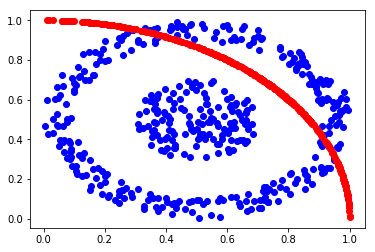

In [47]:
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.plot(X_new[:, 0], X_new[:, 1], 'ro')
plt.show()

In [48]:
kmeans = MyKMeans(2).fit(X_new)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
X_0 = X_new[labels == 0]
X_1 = X_new[labels == 1]

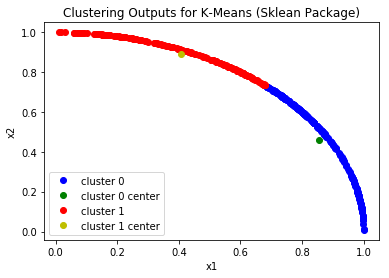

In [49]:
plt.plot(X_0[:, 0], X_0[:, 1], 'bo', label='cluster 0')
plt.plot(centers[0, 0], centers[0, 1], 'go', label='cluster 0 center')
plt.plot(X_1[:, 0], X_1[:, 1], 'ro', label='cluster 1')
plt.plot(centers[1, 0], centers[1, 1], 'yo', label='cluster 1 center')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Clustering Outputs for K-Means (Sklean Package)')
plt.show()